In [56]:
import pandas as pd
import numpy as np

path = "//home/font/Data/MM/neepu/"
filename_sanya_hp= '三亚房价.csv'
filename_haikou_hp = '海口房价.csv'
data_sanya_hp = pd.read_csv((path+filename_sanya_hp),index_col='Time')
data_haikou_hp = pd.read_csv((path+filename_haikou_hp),index_col='Time')

print(data_sanya_hp.columns)
data_sanya_hp.index = pd.to_datetime(data_sanya_hp.index)

data_haikou_hp.index = pd.to_datetime(data_haikou_hp.index)

Index(['HP'], dtype='object')


In [57]:
data_sanya_hp = data_sanya_hp['2013-5':'2018-4']
data_haikou_hp = data_haikou_hp['2013-5':'2018-4']
data_sanya_hp['2018']

,HP
Time,
2018-01-01,35417
2018-02-01,34931
2018-03-01,37580
2018-04-01,36663


In [4]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
    
# 移动平均图
def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.ewma(timeSeries, span=size)

    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

'''
　　Unit Root Test
   The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
   root, with the alternative that there is no unit root. That is to say the
   bigger the p-value the more reason we assert that there is a unit root
'''
def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()

/home/font/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<Figure size 432x288 with 0 Axes>

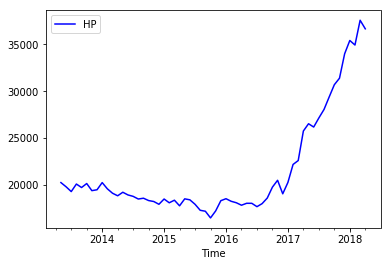

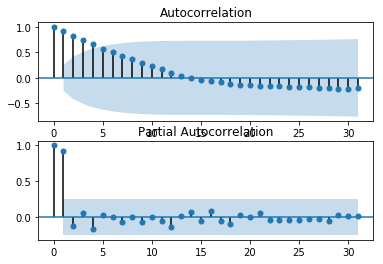

Test Statistic                 -2.668626
p-value                         0.079627
#Lags Used                     11.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64

In [5]:
# draw_trend(data_sanya_hp)
draw_ts(data_sanya_hp)
draw_acf_pacf(data_sanya_hp)
testStationarity(data_sanya_hp['HP'])

观察法，通俗的说就是通过观察序列的趋势图与相关图是否随着时间的变化呈现出某种规律。所谓的规律就是时间序列经常提到的周期性因素，现实中遇到得比较多的是线性周期成分，这类周期成分可以采用差分或者移动平均来解决，而对于非线性周期成分的处理相对比较复杂，需要采用某些分解的方法。下图为航空数据的线性图，可以明显的看出它具有年周期成分和长期趋势成分。平稳序列的自相关系数会快速衰减，下面的自相关图并不能体现出该特征，所以我们有理由相信该序列是不平稳的。

单位根检验：ADF是一种常用的单位根检验方法，他的原假设为序列具有单位根，即非平稳，对于一个平稳的时序数据，就需要在给定的置信水平上显著，拒绝原假设。检验结果中p值=0.07，说明能够拒绝原假设。

由前面的分析可知，该序列是平稳的，平稳性是时间序列分析的前提条件，但是我们仍然可以对其进行进一步的平稳性处理来进一步增强其平稳性。
移动平均即利用一定时间间隔内的平均值作为某一期的估计值，而指数平均则是用变权的方法来计算均值。

从下面的统计检验结果可以看出，经过12阶差分和1阶差分后，该序列更加满足平稳性的要求了。

In [6]:
diff_12 = data_sanya_hp.diff(12)
diff_12.dropna(inplace=True)
diff_12_1 = diff_12.diff(1)
diff_12_1.dropna(inplace=True)
testStationarity(diff_12_1['HP'])

Test Statistic                 -3.700554
p-value                         0.004105
#Lags Used                      3.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64

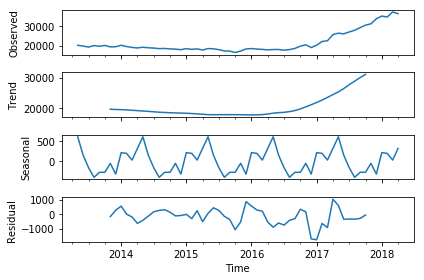

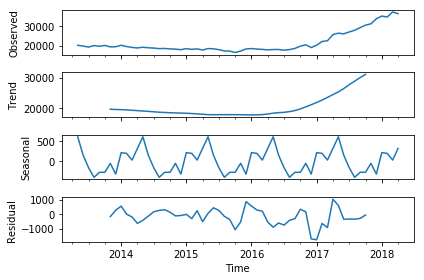

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_sanya_hp, model="additive")
'''
所谓分解就是将时序数据分离成不同的成分。
statsmodels使用的X-11分解过程，它主要将时序数据分离成长期趋势、季节趋势和随机成分。
与其它统计软件一样，statsmodels也支持两类分解模型，加法模型和乘法模型，
这里使用加法，乘法只需将model的参数设置为"multiplicative"即可。
'''
# trend = decomposition.trend
# seasonal = decomposition.seasonal
# residual = decomposition.resid

decomposition.plot()

In [31]:
'''
在前面的分析可知，该序列具有明显的季节周期(年周期)。
对于年周期成分我们使用窗口为12的移动平滑进行处理，对于长期趋势成分我们采用1阶差分来进行处理。
'''
rol_mean = data_sanya_hp.rolling(window=12).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
testStationarity(ts_diff_1['HP'])

Test Statistic                 -3.009075
p-value                         0.034056
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64

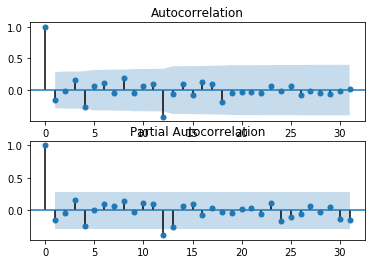

In [9]:
'''
观察其统计量发现该序列在置信水平为95%的区间下并不显著，我们对其进行再次一阶差分。
再次差分后的序列其自相关具有快速衰减的特点，t统计量在99%的置信水平下是显著的
'''
ts_diff_2 = ts_diff_1.diff(1)
ts_diff_2.dropna(inplace=True)
draw_acf_pacf(ts_diff_2)

In [32]:
'''
数据平稳后，需要对模型定阶，即确定p、q的阶数。
观察上图，发现自相关和偏相系数都存在拖尾的特点，并且他们都具有明显的一阶相关性，所以我们设定p=1, q=1。
下面就可以使用ARMA模型进行数据拟合。 
'''
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff_2, order=(1, 1)) 
result_arma = model.fit( disp=-1, method='css')
ts_diff_2

,HP
Time,
2014-06-01,13.333333
2014-07-01,30.083333
2014-08-01,-90.833333
2014-09-01,38.333333
2014-10-01,-56.416667
2014-11-01,54.583333
2014-12-01,-32.416667
2015-01-01,-16.833333
2015-02-01,21.833333


In [40]:
'''
模型拟合完后，我们就可以对其进行预测了。由于ARMA拟合的是经过相关预处理后的数据，故其预测值需要通过相关逆变换进行还原。
'''
def predict_diff_recover(predict_ts=predict_ts,ts_diff_1 = ts_diff_1):
    # 一阶差分还原
    diff_shift_ts = ts_diff_1.shift(1)
    diff_recover_1 = predict_ts.add(diff_shift_ts['HP'])
    # 再次一阶差分还原
    rol_shift_ts = rol_mean.shift(1)
    diff_recover = diff_recover_1.add(rol_shift_ts['HP'])
    # 移动平均还原
    rol_sum = data_sanya_hp.rolling(window=11).sum()
    rol_recover = np.array(diff_recover)*12 - np.array(rol_sum.shift(1)).T[0][11:]
    # 没做对数处理,此处不需要还原
    # # 对数还原
    # log_recover = np.exp(rol_recover)
    # log_recover.dropna(inplace=True)

    rol_recover = pd.DataFrame(rol_recover)
    
    return rol_recover
predict_ts = result_arma.predict()
rol_recover = predict_diff_recover()

我们使用均方根误差（RMSE）来评估模型样本内拟合的好坏。利用该准则进行判别时，需要剔除“非预测”数据的影响。

<Figure size 432x288 with 0 Axes>

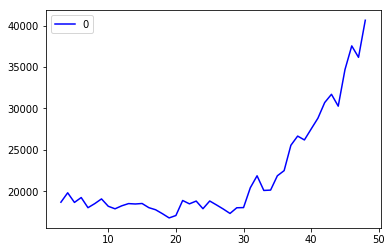

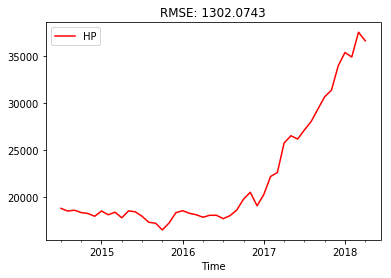

[1302.07433979]


In [25]:
data_sanya_hp_new = data_sanya_hp[14:]  # 过滤没有预测的记录
rol_recover_new = rol_recover[3:]
plt.figure(facecolor='white')
rol_recover_new.plot(color='blue', label='Predict')
data_sanya_hp_new.plot(color='red', label='Original')
plt.legend(loc='best')
rol_recover_new
data_sanya_hp_new.size
# print((np.asarray(rol_recover_new)-np.asarray(data_sanya_hp_new))**2)
RMSE = np.sqrt(sum( (np.asarray(rol_recover_new)-np.asarray(data_sanya_hp_new))**2 )/data_sanya_hp_new.size )
plt.title('RMSE: %.4f'% RMSE)
plt.show()
print(RMSE)

In [13]:
from dateutil.relativedelta import relativedelta
def _add_new_data(ts, dat, type='day'):
    if type == 'day':
            new_index = ts.index[-1] + relativedelta(days=1)
    elif type == 'month':
        new_index = ts.index[-1] + relativedelta(months=1)
    ts[new_index] = dat

def add_today_data(model, ts,  data, d, type='day'):
    _add_new_data(ts, data, type)  # 为原始序列添加数据
    # 为滞后序列添加新值
    d_ts = diff_ts(ts, d)
    model.add_today_data(d_ts[-1], type)

def forecast_next_day_data(model, type='day'):
    if model == None:
        raise ValueError('No model fit before')
    fc = model.predict(type)
    return predict_diff_recover(fc, [12, 1])

<Figure size 432x288 with 0 Axes>

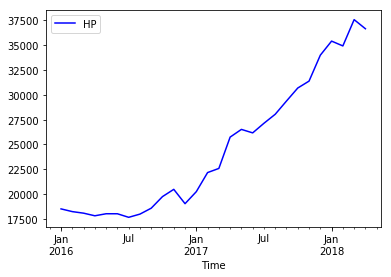

In [67]:
data_sanya_hp_new_2 = data_sanya_hp['2016-01-01':]

draw_ts(data_sanya_hp_new_2[:])

# draw_acf_pacf(data_sanya_hp_new_2[:])

# testStationarity(data_sanya_hp_new_2['HP'])

In [70]:
data_sanya_hp_new_2['HP'] =np.array(data_sanya_hp_new_2['HP'],dtype=np.float)
model = ARMA(data_sanya_hp_new_2, order=(0, 0)) 
result_arma_2 = model.fit( disp=-1, method='css')
predict_data = result_arma.predict('2018-5-01', '2019-5-01', dynamic=True)
print(predict_data)
print(result_arma.cov_params)

2018-05-01    37297.521087
2018-06-01    39169.053334
2018-07-01    38891.213838
2018-08-01    40059.071931
2018-09-01    40699.224704
2018-10-01    40420.264562
2018-11-01    41192.116110
2018-12-01    41271.540525
2019-01-01    41292.642352
2019-02-01    41720.959409
2019-03-01    41499.989809
2019-04-01    41425.900088
2019-05-01    41357.111009
Freq: MS, dtype: float64
<bound method ARMAResults.cov_params of <statsmodels.tsa.arima_model.ARMAResultsWrapper object at 0x7f3116f99438>>


/home/font/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [43]:
predict_dta = result_arma.predict('2018-5-01', '2019-6-01', dynamic=True)

def do_it(predict_dta):
    diff_shift_ts = ts_diff_1.shift(1)
    diff_recover_1 = predict_dta.add(diff_shift_ts['HP'])
    # 再次一阶差分还原
    rol_shift_ts = rol_mean.shift(1)
    diff_recover = diff_recover_1.add(rol_shift_ts['HP'])
    # 移动平均还原
    rol_sum = data_sanya_hp.rolling(window=11).sum()
    
    print(diff_recover)
    
    rol_recover = np.array(diff_recover[14:])*12 - np.array(rol_sum.shift(1)).T[0][11:]

    predict_dta_new = pd.DataFrame(rol_recover)
    
    return predict_dta_new

predict_dta_new = do_it(predict_dta)

# print(predict_dta_new)

# fig, ax = plt.subplots(figsize=(12, 8))
# ax = data_sanya_hp.ix['2000':].plot(ax=ax)
# fig = result_arma.plot_predict('2018-5-01', '2019-6-01', dynamic=True, ax=ax, plot_insample=False)
# plt.show()

2014-04-01   NaN
2014-05-01   NaN
2014-06-01   NaN
2014-07-01   NaN
2014-08-01   NaN
2014-09-01   NaN
2014-10-01   NaN
2014-11-01   NaN
2014-12-01   NaN
2015-01-01   NaN
2015-02-01   NaN
2015-03-01   NaN
2015-04-01   NaN
2015-05-01   NaN
2015-06-01   NaN
2015-07-01   NaN
2015-08-01   NaN
2015-09-01   NaN
2015-10-01   NaN
2015-11-01   NaN
2015-12-01   NaN
2016-01-01   NaN
2016-02-01   NaN
2016-03-01   NaN
2016-04-01   NaN
2016-05-01   NaN
2016-06-01   NaN
2016-07-01   NaN
2016-08-01   NaN
2016-09-01   NaN
              ..
2017-01-01   NaN
2017-02-01   NaN
2017-03-01   NaN
2017-04-01   NaN
2017-05-01   NaN
2017-06-01   NaN
2017-07-01   NaN
2017-08-01   NaN
2017-09-01   NaN
2017-10-01   NaN
2017-11-01   NaN
2017-12-01   NaN
2018-01-01   NaN
2018-02-01   NaN
2018-03-01   NaN
2018-04-01   NaN
2018-05-01   NaN
2018-06-01   NaN
2018-07-01   NaN
2018-08-01   NaN
2018-09-01   NaN
2018-10-01   NaN
2018-11-01   NaN
2018-12-01   NaN
2019-01-01   NaN
2019-02-01   NaN
2019-03-01   NaN
2019-04-01   N

<Figure size 432x288 with 0 Axes>

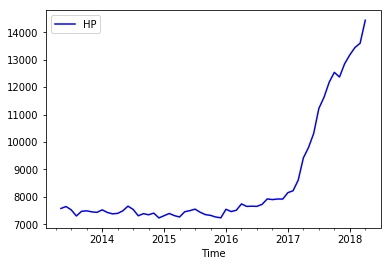

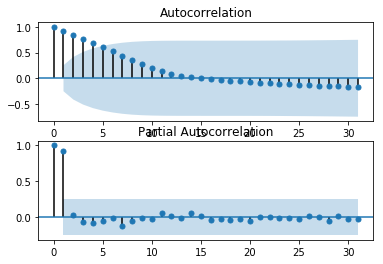

Test Statistic                  1.190008
p-value                         0.995916
#Lags Used                      3.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64

In [22]:
# draw_trend(data_haikou_hp)
draw_ts(data_haikou_hp)
draw_acf_pacf(data_haikou_hp)
testStationarity(data_haikou_hp['HP'])